Tải bộ dữ liệu clean về

In [ ]:
!wget https://huggingface.co/namkunerr/YOLOv1/resolve/main/datasets.zip

--2025-05-28 23:57:14--  https://huggingface.co/namkunerr/YOLOv1/resolve/main/datasets.zip
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.34, 13.35.202.121, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/cd/6f/cd6f6d2118aa17caf00f2fd78f5e23615a0603eb287389c0e1a6495aabd35bdd/d2a84346d69dd64abf0bd8626963e16d2ffbb83da4cb00c153b64f2525c01fe8?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27datasets.zip%3B+filename%3D%22datasets.zip%22%3B&response-content-type=application%2Fzip&Expires=1748480235&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0ODQ4MDIzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2NkLzZmL2NkNmY2ZDIxMThhYTE3Y2FmMDBmMmZkNzhmNWUyMzYxNWEwNjAzZWIyODczODljMGUxYTY0OTVhYWJkMzViZGQvZDJhODQzNDZkNjlkZDY0YWJmMGJkODYyNjk2M2UxNmQyZmZiYjgzZGE0Y2IwMGMxNTNiNjRmMjUyNWMwM

In [ ]:
!unzip /content/datasets.zip >/dev/null 2>&1

Tải bộ dữ liệu nhiễu về

In [ ]:
!wget https://huggingface.co/namkunerr/YOLOv1/resolve/main/noise.zip

--2025-05-28 23:58:16--  https://huggingface.co/namkunerr/YOLOv1/resolve/main/noise.zip
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.121, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/cd/6f/cd6f6d2118aa17caf00f2fd78f5e23615a0603eb287389c0e1a6495aabd35bdd/d652ebd1caee91dd24fabf8ba22597682a5c6bdd105270bdcc5f0b1780b196e2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27noise.zip%3B+filename%3D%22noise.zip%22%3B&response-content-type=application%2Fzip&Expires=1748480296&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0ODQ4MDI5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2NkLzZmL2NkNmY2ZDIxMThhYTE3Y2FmMDBmMmZkNzhmNWUyMzYxNWEwNjAzZWIyODczODljMGUxYTY0OTVhYWJkMzViZGQvZDY1MmViZDFjYWVlOTFkZDI0ZmFiZjhiYTIyNTk3NjgyYTVjNmJkZDEwNTI3MGJkY2M1ZjBiMTc4MGIxOTZlMj9yZX

In [ ]:
!unzip noise.zip >/dev/null 2>&1

In [ ]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.4 MB/s eta 0:00:00


Sinh bộ dữ liệu bằng cách trộn 2 bộ dữ liệu nhiễu và sạch

In [ ]:
import librosa
import numpy as np
import os
import glob
import soundfile as sf

sr = 8000  # Sample rate
segment_length = 8000  # Độ dài mỗi đoạn 1/8 giây
output_dir = "data"  # Thư mục lưu đoạn âm thanh

# Load danh sách tệp
noisefiles = glob.glob('/content/noise/*.wav')  # Đường dẫn đến tệp nhiễu
files = glob.glob('/content/datasets/*.wav')  # Đường dẫn đến tệp sạch

def load_wav(filename, target_sr=8000):
    wav, _ = librosa.load(filename, sr=target_sr, mono=True)
    return wav

def repeat_and_crop_noise(noise, target_length):
    """
    Lặp lại đoạn nhiễu để có độ dài lớn hơn hoặc bằng đoạn âm thanh sạch.
    Sau đó cắt đoạn nhiễu có độ dài chính xác bằng đoạn âm thanh sạch.
    """
    if len(noise) < target_length:
        repeats = int(np.ceil(target_length / len(noise)))
        noise = np.tile(noise, repeats)[:target_length]
    else:
        noise = noise[:target_length]
    return noise

def add_white_noise(data, factor=0.3):
    noise = np.random.normal(0, factor * np.max(data), size=data.shape)
    return data + noise

def add_background_noise(clean_wav, noise_wav, factor=0.3):
    noise_wav = repeat_and_crop_noise(noise_wav, len(clean_wav))
    return clean_wav + factor * noise_wav

def split_audio_and_save(wav, clean_wav, segment_length, filename):
    assert len(wav) == len(clean_wav)
    num_segments = len(wav) // segment_length  # Số đoạn có thể lấy đủ 1 giây

    os.makedirs(f"{output_dir}/noise", exist_ok=True)
    os.makedirs(f"{output_dir}/clean", exist_ok=True)

    for i in range(num_segments):
        segment = wav[i * segment_length:(i + 1) * segment_length]
        clean_segment = clean_wav[i * segment_length:(i + 1) * segment_length]

        segment_path = os.path.join(output_dir, "noise", f"{os.path.basename(filename).replace('.wav', '')}_{i}.wav")
        clean_segment_path = os.path.join(output_dir, "clean", f"{os.path.basename(filename).replace('.wav', '')}_{i}.wav")

        sf.write(segment_path, segment, sr)
        sf.write(clean_segment_path, clean_segment, sr)

# Xử lý từng tệp
for filepath in files:
    clean_wav = load_wav(filepath)

    # Bỏ qua các tệp có thời lượng < 1 giây
    if len(clean_wav) < segment_length:
        print(f"Skipping {filepath} (duration < 1s)")
        continue

    noise_file = np.random.choice(noisefiles)
    noise_wav = load_wav(noise_file)

    # Thêm nhiễu trắng
    clean_noisy = add_white_noise(clean_wav)

    # Thêm nhiễu nền từ tệp
    mixed_noisy = add_background_noise(clean_noisy, noise_wav)

    # Cắt đoạn và lưu lại
    split_audio_and_save(mixed_noisy, clean_wav, segment_length, filepath)


Skipping /content/datasets/493.wav (duration < 1s)
Skipping /content/datasets/1062.wav (duration < 1s)
Skipping /content/datasets/1079.wav (duration < 1s)
Skipping /content/datasets/780.wav (duration < 1s)
Skipping /content/datasets/258.wav (duration < 1s)
Skipping /content/datasets/381.wav (duration < 1s)
Skipping /content/datasets/449.wav (duration < 1s)
Skipping /content/datasets/1562.wav (duration < 1s)
Skipping /content/datasets/813.wav (duration < 1s)
Skipping /content/datasets/357.wav (duration < 1s)
Skipping /content/datasets/211.wav (duration < 1s)
Skipping /content/datasets/1190.wav (duration < 1s)
Skipping /content/datasets/857.wav (duration < 1s)
Skipping /content/datasets/1396.wav (duration < 1s)
Skipping /content/datasets/143.wav (duration < 1s)
Skipping /content/datasets/501.wav (duration < 1s)
Skipping /content/datasets/711.wav (duration < 1s)
Skipping /content/datasets/1242.wav (duration < 1s)
Skipping /content/datasets/1666.wav (duration < 1s)
Skipping /content/datase

Thử in giá trị của một file âm thanh

In [ ]:
def load_wav(filename, target_sr=8000):
    wav, sample_rate = librosa.load(filename, sr=target_sr, mono=True)
    print("sample_rate",sample_rate)
    return wav
audio = load_wav("/content/data/noise/1000_0.wav")
print(audio)
print(len(audio))


sample_rate 8000
[ 0.03665161 -0.1387024  -0.08059692 ...  0.209198    0.1701355
  0.01913452]
8000


Thử in một đoạn dữ liệu nhỏ

In [ ]:
from IPython.display import Audio
import librosa
y,sr = librosa.load("/content/data/clean/1000_0.wav",sr = 8000)
print("sr",sr)
print("len(y)",len(y))
Audio("/content/data/clean/1000_0.wav")

sr 8000
len(y) 8000


Thử biến đổi STFT bằng tensorflow

In [ ]:
import tensorflow as tf
frame_length=128
n_fft=  128
frame_step =64
x =tf.signal.stft(audio, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
print(x)
print(x.shape)

tf.Tensor(
[[ 0.06342457+0.j         -0.03246033+0.6201498j   0.35758743-0.49175718j
  ...  0.15986598+0.0431006j   0.02233557+0.2569142j
   0.08785315+0.j        ]
 [ 0.97489023+0.j         -0.60560346-0.43157592j  0.19257924+0.63221467j
  ...  0.384101  +0.08946255j -0.54901385-0.13902837j
   0.46183395+0.j        ]
 [ 0.83432007+0.j         -0.34619895+0.21255153j -0.20818825+0.04541853j
  ... -0.15737644+0.2799775j  -0.12246578-0.54852885j
   0.5466782 +0.j        ]
 ...
 [-0.84550834+0.j          3.4697986 +1.4877952j  -5.1912417 -1.9163303j
  ...  0.09611797-0.3181485j  -0.13371658+0.27904946j
   0.28647387+0.j        ]
 [-0.931371  +0.j          4.206564  -0.04598673j -6.9533377 +0.02523217j
  ...  0.0433259 +0.79060173j -0.32160163-0.43092677j
   0.30869088+0.j        ]
 [-1.3444438 +0.j          3.6766798 -2.8349757j  -5.1387253 +3.858449j
  ... -0.05992341+0.49545145j  0.6421528 -0.02447689j
  -0.81208944+0.j        ]], shape=(124, 65), dtype=complex64)
(124, 65)


Cách mà STFT hoạt động

In [ ]:
data =np.array([1,2,2,1,3,4,5,1],np.float32)
stft_result = librosa.stft(data, n_fft=4, hop_length=2,center= False)
print(stft_result)
print(stft_result.shape)

[[ 3.5+0.j   5.5+0.j   7.5+0.j ]
 [-2. -0.5j -3. +1.5j -5. -1.5j]
 [ 0.5+0.j   0.5+0.j   2.5+0.j ]]
(3, 3)


Định nghĩa một số tham số

In [2]:
frame_length = 1022
n_fft = 1022
frame_step = 300
n_sample = 8000
sample_rate = 8000
n_frame  = (n_sample - frame_length)//frame_step +1
n_freq = n_fft//2 + 1
batch_size = 64
print("n_frame",n_frame)
print("n_freq",n_freq)

n_frame 24
n_freq 512


Quản lí bộ dataset bằng NoiseDataset

In [ ]:
import tensorflow as tf

class NoiseDataset(tf.data.Dataset):
    def __new__(cls, noisy_files, clean_files,
                sr=sample_rate,
                frame_length=frame_length,
                n_fft=n_fft,
                frame_step=frame_step,
                batch_size=batch_size):
        """
        noisy_files: Danh sách đường dẫn đến file âm thanh có nhiễu
        clean_files: Danh sách đường dẫn đến file âm thanh sạch
        sr: Sample rate
        n_fft: Số điểm FFT cho STFT
        frame_length: Độ dài frame khi thực hiện STFT
        frame_step: Bước nhảy khi thực hiện STFT
        batch_size: Kích thước batch khi load dữ liệu
        """
        assert len(clean_files) == len(noisy_files), "Số lượng file sạch và nhiễu phải bằng nhau!"

        dataset = tf.data.Dataset.from_tensor_slices((clean_files, noisy_files))

        def process_audio(clean_path, noisy_path):
            """ Load file audio bằng TensorFlow, tính STFT """
            wav_clean = cls.load_wav(clean_path, sr)
            wav_noisy = cls.load_wav(noisy_path, sr)

            spectrogram_noisy, spectrogram_clean = cls.convert_to_spectrogram(wav_noisy, wav_clean, n_fft, frame_length, frame_step)
            # spectrogram_noisy = spectrogram_noisy[:, :-1, :]  # Loại bỏ tần số cuối
            # spectrogram_clean = spectrogram_clean[:, :-1, :]
            spectrogram_noisy = cls.split_real_imag(spectrogram_noisy)
            spectrogram_clean = cls.split_real_imag(spectrogram_clean)

            return spectrogram_noisy, spectrogram_clean

        dataset = dataset.map(process_audio, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    @staticmethod
    def load_wav(filename, target_sr=8000):
        """ Load file âm thanh bằng TensorFlow """
        file_content = tf.io.read_file(filename)
        wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)  # Chuyển từ (samples, 1) -> (samples,)


        return wav

    @staticmethod
    def convert_to_spectrogram(wav_noisy, wav_clean, n_fft, frame_length, frame_step):
        """ Tính toán STFT của tín hiệu """
        spectrogram_noisy = tf.signal.stft(wav_noisy, frame_length=frame_length, frame_step=frame_step, fft_length=n_fft)
        spectrogram_clean = tf.signal.stft(wav_clean, frame_length=frame_length, frame_step=frame_step, fft_length=n_fft)
        return spectrogram_noisy, spectrogram_clean

    @staticmethod
    def split_real_imag(spectrogram):
        """ Tách phần thực và ảo của phổ """
        real_part = tf.math.real(spectrogram)
        imag_part = tf.math.imag(spectrogram)
        stacked = tf.stack([real_part, imag_part], axis=-1)  # (time, freq, 2)

        return stacked


Chia bộ dataset thành 2 phần train và test mỗi bộ tỉ lệ 90/10

In [ ]:
from sklearn.model_selection import train_test_split
import glob
noise_files = glob.glob('/content/data/noise/*.wav')
clean_files = [i.replace("noise","clean") for i in noise_files]
assert len(clean_files) == len(noise_files)
noisy_train, noisy_test, clean_train, clean_test = train_test_split(
    noise_files, clean_files, test_size=0.1, random_state=42
)

print("Train set:")
print(noisy_train)
print(clean_train)

print("\nTest set:")
print(noisy_test)
print(clean_test)

Train set:
['/content/data/noise/1645_0.wav', '/content/data/noise/1752_0.wav', '/content/data/noise/1567_1.wav', '/content/data/noise/927_0.wav', '/content/data/noise/1827_0.wav', '/content/data/noise/1869_1.wav', '/content/data/noise/81_5.wav', '/content/data/noise/959_2.wav', '/content/data/noise/1393_2.wav', '/content/data/noise/1524_0.wav', '/content/data/noise/215_5.wav', '/content/data/noise/198_9.wav', '/content/data/noise/24_7.wav', '/content/data/noise/1400_7.wav', '/content/data/noise/1772_2.wav', '/content/data/noise/604_3.wav', '/content/data/noise/1383_2.wav', '/content/data/noise/1854_3.wav', '/content/data/noise/1276_0.wav', '/content/data/noise/643_2.wav', '/content/data/noise/28_0.wav', '/content/data/noise/1201_0.wav', '/content/data/noise/88_1.wav', '/content/data/noise/1393_1.wav', '/content/data/noise/1753_3.wav', '/content/data/noise/297_4.wav', '/content/data/noise/162_0.wav', '/content/data/noise/498_0.wav', '/content/data/noise/1742_0.wav', '/content/data/nois

Dataloader

In [ ]:
train_dataset = NoiseDataset(noisy_train, clean_train)
test_dataset = NoiseDataset(noisy_test, clean_test)


In [ ]:
print(len(train_dataset))

91


In [ ]:
for x, y in train_dataset.take(1):
    print(f"Feature shape: {x.shape}, Label shape: {y.shape}")


Feature shape: (64, 24, 512, 2), Label shape: (64, 24, 512, 2)


Model sử dụng cho Arduino

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.models import Model
def unet_2blocks(input_size=(12, 64, 2), num_classes=2):
    inputs = Input(shape=input_size)

    ### Encoder Block 1
    c1 = Conv2D(8, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.2)(c1)
    c1 = Conv2D(8, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.2)(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    ### Encoder Block 2
    c2 = Conv2D(16, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.2)(c2)
    c2 = Conv2D(16, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.2)(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    ### Bottleneck
    b = Conv2D(16, (3, 3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = LeakyReLU(alpha=0.2)(b)
    b = Conv2D(16, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = LeakyReLU(alpha=0.2)(b)

    ### Decoder Block 2
    u2 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(b)
    u2 = concatenate([u2, c2])
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.2)(u2)
    u2 = Conv2D(16, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.2)(u2)

    ### Decoder Block 3
    u3 = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, c1])
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.2)(u3)
    u3 = Conv2D(8, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.2)(u3)

    ### Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='linear')(u3)

    model = Model(inputs=inputs, outputs=outputs)
    return model
model = unet_2blocks(input_size=( n_frame, n_freq, 2), num_classes=2)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 512,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 512,   │        152 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 512,   │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 24, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 512,   │        584 │ leaky_re_lu[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 512,   │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 24, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 256,   │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 256,   │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256,   │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 12, 256,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 256,   │      2,320 │ leaky_re_lu_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256,   │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 12, 256,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 128,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 128,    │      2,320 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 128,    │         64 │ conv2d_4[0][0]  

 Total params: 18,754 (73.26 KB)

 Trainable params: 18,450 (72.07 KB)

 Non-trainable params: 304 (1.19 KB)

Model sử dụng cho Python, lý do là do tài nguyên Python lớn nên em muốn thêm mốt số lớp đế nó chính xác hơn

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.models import Model

def unet_3blocks(input_size=(12, 64, 2), num_classes=2):
    inputs = Input(shape=input_size)


# Encoder Block 1
    c1 = Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.2)(c1)
    c1 = Conv2D(16, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.2)(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    # Encoder Block 2
    c2 = Conv2D(32, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.2)(c2)
    c2 = Conv2D(32, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.2)(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    # Encoder Block 3 (mới thêm)
    c3 = Conv2D(64, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.2)(c3)
    c3 = Conv2D(64, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.2)(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), padding='same')(p3)
    b = BatchNormalization()(b)
    b = LeakyReLU(alpha=0.2)(b)
    b = Conv2D(128, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = LeakyReLU(alpha=0.2)(b)

    # Decoder Block 1 (mới thêm)
    u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c3])
    u1 = BatchNormalization()(u1)
    u1 = LeakyReLU(alpha=0.2)(u1)
    u1 = Conv2D(64, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = LeakyReLU(alpha=0.2)(u1)

    # Decoder Block 2 (sửa lại từ Decoder Block 2 cũ)
    u2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, c2])
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.2)(u2)
    u2 = Conv2D(32, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.2)(u2)

    # Decoder Block 3 (sửa lại từ Decoder Block 3 cũ)
    u3 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, c1])
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.2)(u3)
    u3 = Conv2D(16, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.2)(u3)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='linear')(u3)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_3blocks(input_size=( n_frame, n_freq, 2), num_classes=2)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 512,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 512,   │        304 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 512,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 24, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 512,   │      2,320 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 512,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 24, 512,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 256,   │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 256,   │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256,   │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 12, 256,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 256,   │      9,248 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256,   │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 12, 256,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 128,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 128,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 128,    │        256 │ conv2d_4[0][0]  

 Total params: 490,434 (1.87 MB)

 Trainable params: 488,802 (1.86 MB)

 Non-trainable params: 1,632 (6.38 KB)

Training

In [ ]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class HistoryLogger(Callback):
    def on_train_begin(self, logs=None):
        self.train_losses = []
        self.val_losses = []
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.lrs.append(float(K.get_value(self.model.optimizer.learning_rate)))

In [ ]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Khởi tạo mô hình UNet với input shape và số class
model = unet_3blocks(input_size=(n_frame, n_freq, 2 ), num_classes=2)

# Loss function và Optimizer với gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
loss_fn = tf.keras.losses.Huber()

model.compile(optimizer=optimizer, loss=loss_fn)

# Callback để lưu trọng số sau mỗi epoch
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only=True,  # Chỉ lưu mô hình tốt nhất
    monitor="val_loss",   # Theo dõi validation loss thay vì train loss
    verbose=1
)

# Các callbacks bổ sung
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_logger = HistoryLogger()

model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback, history_logger]
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.3237
Epoch 1: val_loss improved from inf to 0.29268, saving model to checkpoints/model_epoch_01.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - loss: 0.3232 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 2/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2235
Epoch 2: val_loss improved from 0.29268 to 0.21262, saving model to checkpoints/model_epoch_02.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - loss: 0.2231 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 3/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1756
Epoch 3: val_loss improved from 0.21262 to 0.17929, saving model to checkpoints/model_epoch_03.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.1755 - val_loss: 0.1793 - learning_rate: 0.0010
Epoch 4/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1660
Epoch 4: val_loss improved from 0.17929 to 0.16728, saving model to checkpoints/model_epoch_04.weights.h5
91/91 ━━━

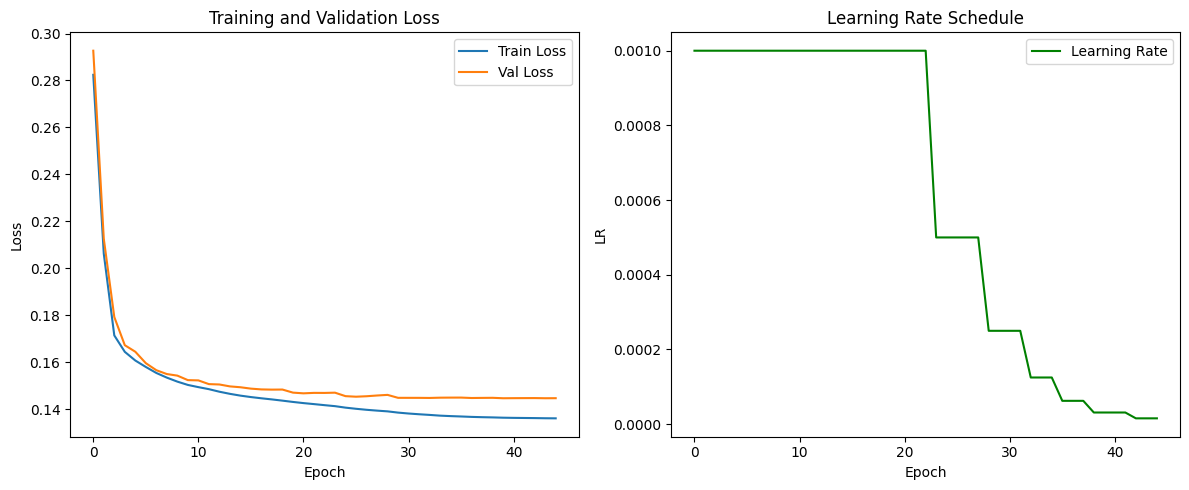

In [ ]:
# Vẽ loss và learning rate
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_logger.train_losses, label='Train Loss')
plt.plot(history_logger.val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot learning rate
plt.subplot(1, 2, 2)
plt.plot(history_logger.lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Learning Rate Schedule')
plt.legend()

plt.tight_layout()
plt.show()

Thử nghiệm trên một số audio

In [ ]:
import tensorflow as tf
import numpy as np

import librosa

import IPython.display as ipd

def play_audio(audio, sr=8000):
    """Phát lại âm thanh trong Jupyter Notebook"""
    return ipd.Audio(audio, rate=sr)

def denoise_audio(file_clean, file_noise,file_mix,file_res, sr=8000, frame_length=frame_length,n_fft=n_fft, frame_step=frame_step):
    """
    Load một file âm thanh nhiễu, xử lý qua model và phát lại âm thanh đã khử nhiễu.

    model: Mô hình khử nhiễu (nhận đầu vào là spectrogram và trả về spectrogram sạch)
    file_path: Đường dẫn đến file âm thanh nhiễu
    sr: Sample rate
    n_fft: Số điểm FFT
    frame_length: Độ dài khung STFT
    frame_step: Bước nhảy STFT
    """
    # 1. Load tệp âm thanh
    noisy = load_wav(file_noise, sr)
    clean = load_wav(file_clean, sr)
    clean = clean[:40000]
    sf.write("audio_clean.wav", clean,samplerate=8000)

    model = unet_3blocks(input_size=(n_frame, n_freq, 2), num_classes=2)
    model.load_weights("/content/checkpoints/model_epoch_40.weights.h5")
    #mix
    wav_noisy_all = noisy*0.3 +clean
    sf.write(file_mix, wav_noisy_all,samplerate=8000)
    all_wav_clean = []
    print("len(wav_noisy)", len(wav_noisy_all))
    #split 800 sample
    for chunk in range(40000//n_sample):
        wav_noisy = wav_noisy_all[chunk*n_sample:(chunk+1)*n_sample]

        spectrogram_noisy = tf.signal.stft(wav_noisy, frame_length=frame_length, frame_step=frame_step, fft_length=n_fft)
        spectrogram_noisy = NoiseDataset.split_real_imag(spectrogram_noisy)
        spectrogram_noisy = tf.expand_dims(spectrogram_noisy, axis=0)  # Thêm batch dimension

        spectrogram_clean = model(spectrogram_noisy, training=False)
        spectrogram_clean = tf.complex(spectrogram_clean[..., 0], spectrogram_clean[..., 1])
        wav_clean = tf.signal.inverse_stft(spectrogram_clean[0], frame_length=frame_length, frame_step=frame_step, fft_length=n_fft)

        all_wav_clean.append(wav_clean)
    # 5. Chuẩn hóa giá trị về [-1, 1]
    all_wav_clean = tf.concat(all_wav_clean, axis=0)
    all_wav_clean = all_wav_clean / tf.reduce_max(tf.abs(all_wav_clean))

    # 6. Phát lại âm thanh
    wav_clean_np = all_wav_clean.numpy()
    wav_clean_np = np.squeeze(wav_clean_np)  # Loại bỏ batch dimension
    print("len(wav_clean_np)",len(wav_clean_np))
    sf.write(file_res, wav_clean_np,samplerate=8000)
    return wav_clean_np

In [ ]:
!pip install sounddevice

In [ ]:
file_clean = "/content/datasets/5.wav"
file_noise = "/content/noise/clap-0.wav"
file_mix = "/content/mix.wav"
file_res = "/content/res.wav"
denoise_audio(file_clean=file_clean,file_noise=file_noise,file_mix=file_mix,file_res=file_res)

sample_rate 8000
sample_rate 8000
len(wav_noisy) 40000
len(wav_clean_np) 39610


array([ 0.0000000e+00, -7.7176040e-08, -1.6442108e-07, ...,
        2.0976287e-07,  2.6128015e-07, -4.8454858e-08], dtype=float32)

Âm thanh sạch

In [ ]:
Audio("audio_clean.wav")

âm thanh nhiễu

In [ ]:
Audio(file_noise)

âm thanh được trộn

In [ ]:
Audio(file_mix)

âm thanh sau khi lọc

In [ ]:
Audio(file_res)

Âm thanh sạch gốc

Âm thanh được trộn gốc

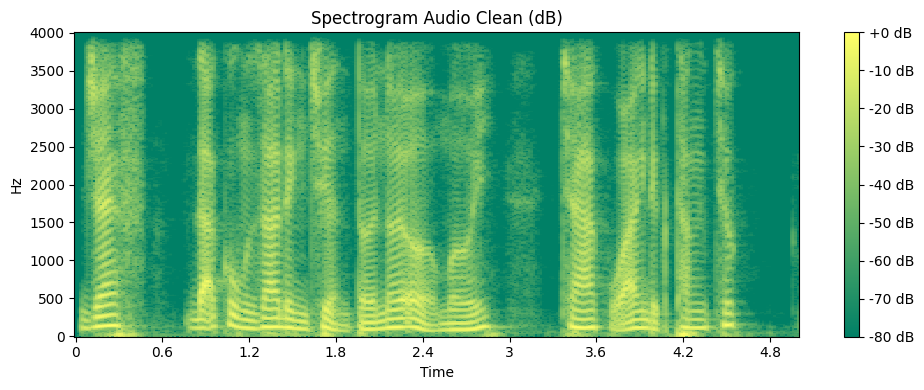

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn file audio
file_path = 'audio_clean.wav'  # hoặc .wav

# Đọc file audio với librosa (trả về mono)
y, sr = librosa.load(file_path, sr=8000)

# Tính STFT
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Hiển thị spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='hz', cmap='summer')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Audio Clean (dB)')
plt.tight_layout()
plt.show()


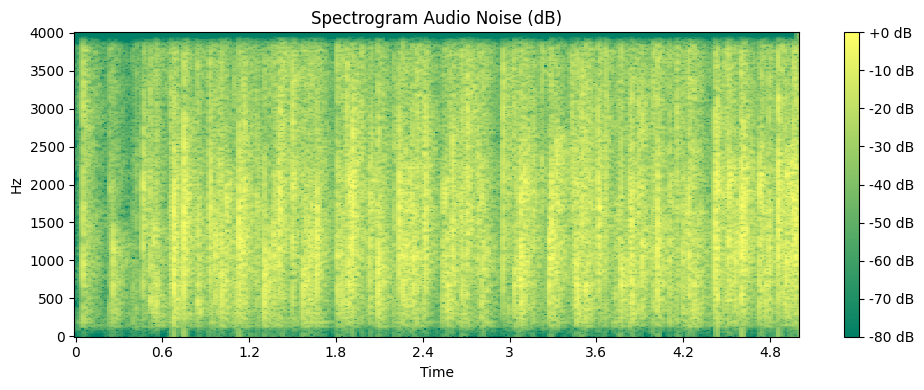

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn file audio
file_path = '/content/noise/clap-0.wav'  # hoặc .wav

# Đọc file audio với librosa (trả về mono)
y, sr = librosa.load(file_path, sr=8000)

# Tính STFT
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Hiển thị spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='hz', cmap='summer')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Audio Noise (dB)')
plt.tight_layout()
plt.show()

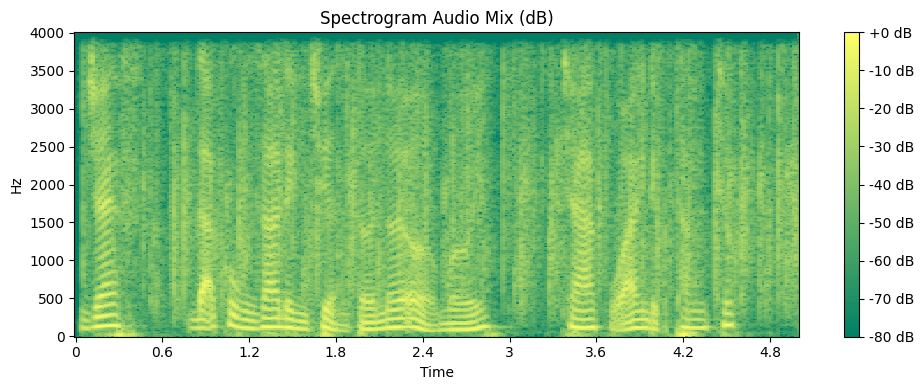

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn file audio
file_path = 'mix.wav'  # hoặc .wav

# Đọc file audio với librosa (trả về mono)
y, sr = librosa.load(file_path, sr=8000)

# Tính STFT
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Hiển thị spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='hz', cmap='summer')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Audio Mix (dB)')
plt.tight_layout()
plt.show()

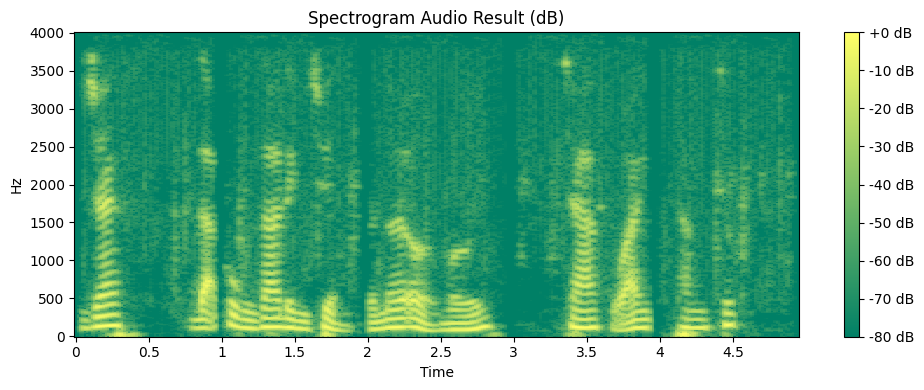

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn file audio
file_path = 'res.wav'  # hoặc .wav

# Đọc file audio với librosa (trả về mono)
y, sr = librosa.load(file_path, sr=8000)

# Tính STFT
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Hiển thị spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='hz', cmap='summer')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Audio Result (dB)')
plt.tight_layout()
plt.show()

In [ ]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
tflite_model_name = 'denoi'
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmpv0sp4r9n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 256, 2), dtype=tf.float32, name='keras_tensor_94')
Output Type:
  TensorSpec(shape=(None, 16, 256, 2), dtype=tf.float32, name=None)
Captures:
  136437646788752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646796816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646797008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646796240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646791056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646796624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646798544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646799120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646799312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136437646798160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136

137520

In [ ]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
c_model_name ="denoi"
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

In [ ]:
# Chuyển đổi model sang TFLite
def representative_dataset():
    for data, _ in train_dataset.take(5800):
        # Giả sử data có shape [batch_size, 16, 256, 2]
        # Nếu batch_size > 1, bạn cần tách ra từng mẫu:
        yield [tf.cast(data[0:1], tf.float32)]  # Lấy từng mẫu batch_size=1
model = unet_3blocks(input_size=(n_frame, n_freq, 2), num_classes=2)
model.load_weights("/content/checkpoints/model_epoch_70.weights.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
# Tuỳ chọn: chỉ dùng int8 nếu phần cứng hỗ trợ
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_quant_model = converter.convert()

with open("denoi.tflite", "wb") as f:
    f.write(tflite_quant_model)

Saved artifact at '/tmp/tmplj5d3to7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 512, 2), dtype=tf.float32, name='keras_tensor_108')
Output Type:
  TensorSpec(shape=(None, 28, 512, 2), dtype=tf.float32, name=None)
Captures:
  132657538902608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507666320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271144400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271141136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507668432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507668048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271147472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271145360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271144784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
!xxd -i denoi.tflite > denoi.h

In [ ]:
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="denoi.tflite")
interpreter.allocate_tensors()

# Lấy thông tin đầu vào/đầu ra
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_keras_tensor_108:0', 'index': 0, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 71, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
tensor_details = interpreter.get_tensor_details()
print("\nAll tensor details:")
for i, tensor in enumerate(tensor_details):
    print(f"\nTensor #{i}:")
    print(tensor)


All tensor details:

Tensor #0:
{'name': 'serving_default_keras_tensor_108:0', 'index': 0, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Tensor #1:
{'name': 'arith.constant', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Tensor #2:
{'name': 'arith.constant1', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([],

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/denoi.tflite")
interpreter.allocate_tensors()
input_data = np.random.rand(1, 28, 512, 2).astype(np.float32)


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

[[[[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]
   ...
   [ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]]

  [[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]
   ...
   [ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]]

  [[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]
   ...
   [-1.6896298  0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]]

  ...

  [[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]
   ...
   [ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]]

  [[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.        -0.8448149]
   ...
   [ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]]

  [[ 0.         0.       ]
   [ 0.         0.       ]
   [ 0.         0.       ]
   ...
   [ 0.         0.       ]
   [ 0.         0.     

In [ ]:
import librosa
def add_background_noise(clean_wav, noise_wav, factor=1.0):
    noise_wav = repeat_and_crop_noise(noise_wav, len(clean_wav))
    return clean_wav + factor * noise_wav


clean = librosa.load("/content/datasets/0.wav",sr=8000)[0]
noise = librosa.load("/content/noise/clap-0.wav",sr=8000)[0]


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("denoi_32.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("denoi_32.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmp54p08bow'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 512, 2), dtype=tf.float32, name='keras_tensor_108')
Output Type:
  TensorSpec(shape=(None, 28, 512, 2), dtype=tf.float32, name=None)
Captures:
  132657538902608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507666320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271144400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271141136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507668432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655507668048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271147472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271145360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132655271144784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Write TFLite model to a C source (or header) file
c_model_name = 'denoi_32'
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="denoi_32.tflite")
interpreter.allocate_tensors()

# Lấy thông tin input và output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# In ra để xem input shape và dtype
print("Input details:", input_details)
print("Output details:", output_details)

# Tạo input giả (hoặc thay bằng input thật của bạn)
input_shape = input_details[0]['shape']
input_data = np.random.rand(*input_shape).astype(input_details[0]['dtype'])

# Gán input vào model
interpreter.set_tensor(input_details[0]['index'], input_data)

# Chạy inference
interpreter.invoke()

# Lấy output
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data)


Input details: [{'name': 'serving_default_keras_tensor_108:0', 'index': 0, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 69, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [[[[ 7.01928139e-03 -9.14306100e-03]
   [ 2.06747977e-03  2.55541643e-03]
   [ 6.15272578e-03 -2.75244168e-03]
   ...
   [ 7.41882529e-03 -1.77249534e-03]
   [ 5.40526444e-03 -8.87330528e

In [ ]:
tensor_details = interpreter.get_tensor_details()
print("\nAll tensor details:")
for i, tensor in enumerate(tensor_details):
    print(f"\nTensor #{i}:")
    print(tensor)


All tensor details:

Tensor #0:
{'name': 'serving_default_keras_tensor_108:0', 'index': 0, 'shape': array([  1,  28, 512,   2], dtype=int32), 'shape_signature': array([ -1,  28, 512,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Tensor #1:
{'name': 'arith.constant', 'index': 1, 'shape': array([8], dtype=int32), 'shape_signature': array([8], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Tensor #2:
{'name': 'arith.constant1', 'index': 2, 'shape': array([16], dtype=int32), 'shape_signature': array([16], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': arr

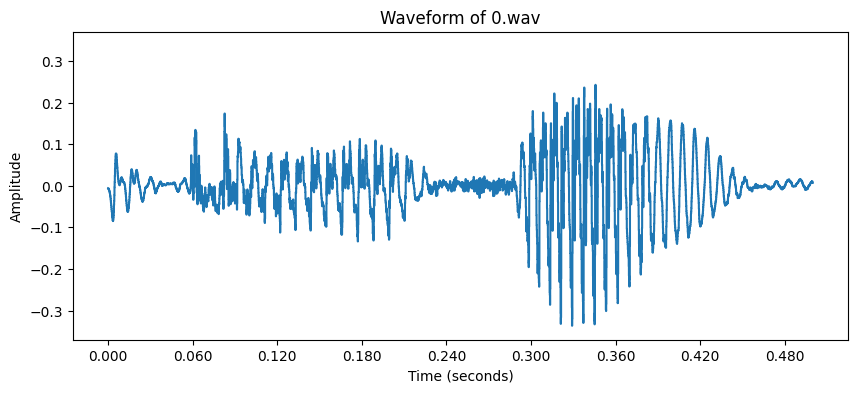

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load tệp âm thanh với tần số lấy mẫu 8000 Hz
clean, sr = librosa.load("/content/datasets/0.wav", sr=8000)
clean = clean[4000:8000]
# Vẽ dạng sóng
plt.figure(figsize=(10, 4))
librosa.display.waveshow(clean, sr=sr)
plt.title("Waveform of 0.wav")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

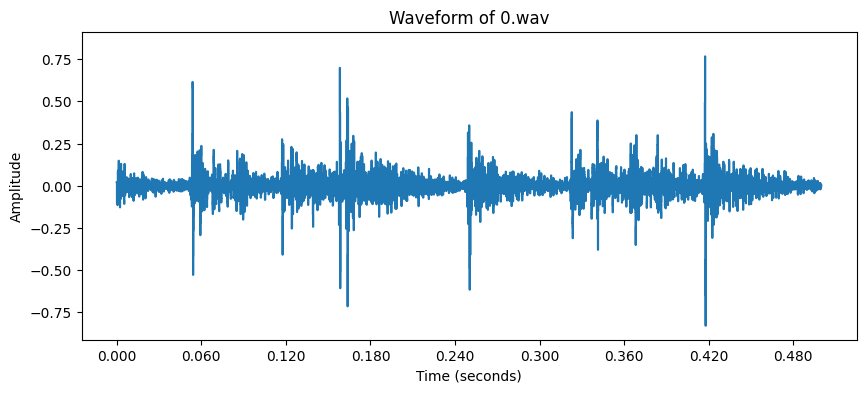

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load tệp âm thanh với tần số lấy mẫu 8000 Hz
noise, sr = librosa.load("/content/noise/clap-0.wav",sr=8000)
noise = noise[10000:14000]
# Vẽ dạng
plt.figure(figsize=(10, 4))
librosa.display.waveshow(noise, sr=sr)
plt.title("Waveform of 0.wav")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

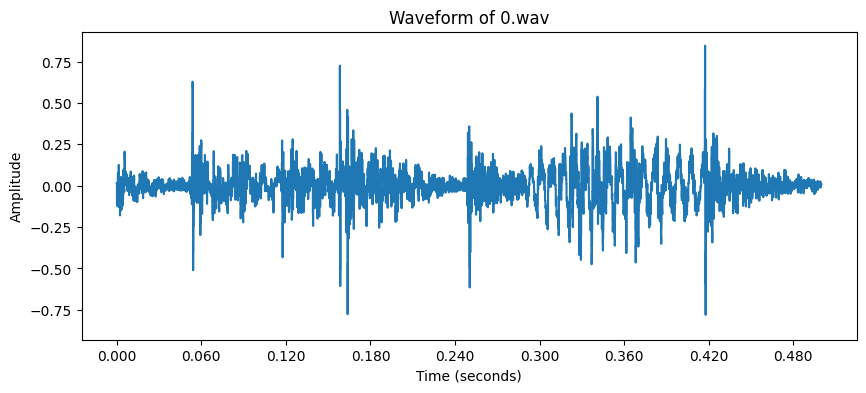

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

mix = add_background_noise(clean, noise)
# Vẽ dạng
plt.figure(figsize=(10, 4))
librosa.display.waveshow(mix, sr=sr)
plt.title("Waveform of 0.wav")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

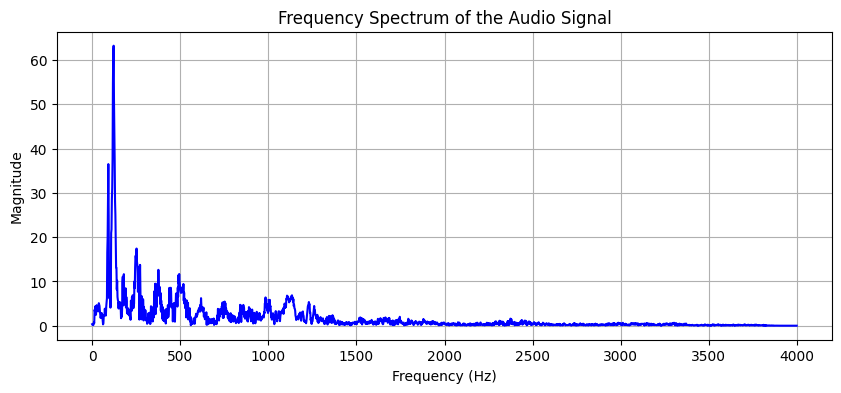

In [ ]:

fft_spectrum = np.fft.fft(clean)  # Biến đổi Fourier
frequencies = np.fft.fftfreq(4000, d=1/sr)  # Trục tần số (Hz)

# Chỉ lấy nửa phổ do tính chất đối xứng của FFT
N_half = 2000
fft_magnitude = np.abs(fft_spectrum[:N_half])  # Độ lớn phổ
frequencies = frequencies[:N_half]  # Chỉ lấy nửa đầu của trục tần số

# Vẽ phổ tần số
plt.figure(figsize=(10, 4))
plt.plot(frequencies, fft_magnitude, color='b')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of the Audio Signal")
plt.grid()
plt.show()


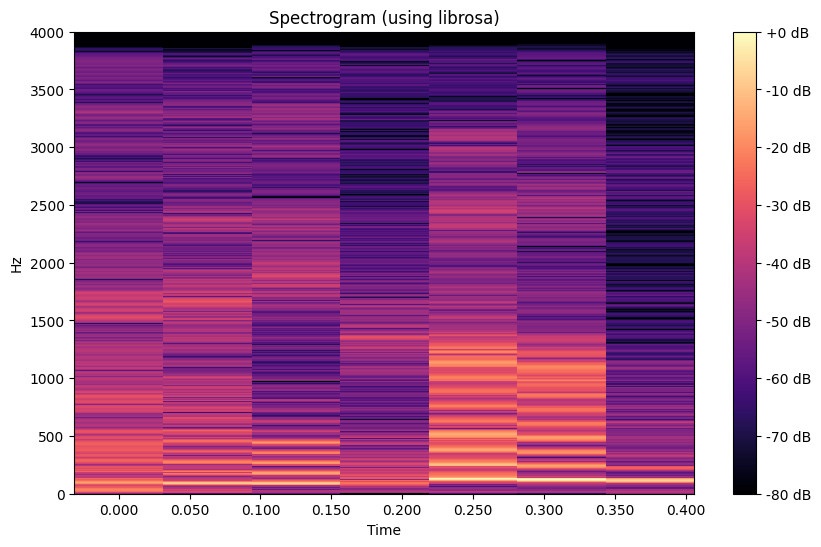

In [ ]:
import librosa
import librosa.display

# Create spectrogram using librosa
D = librosa.stft(clean, n_fft=1000, hop_length=500,center =False)
DB = librosa.power_to_db(np.abs(D)**2, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=8000, hop_length=500, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 4000)  # Set y-axis limit from 0 to 100 Hz
plt.title('Spectrogram (using librosa)')
plt.show()

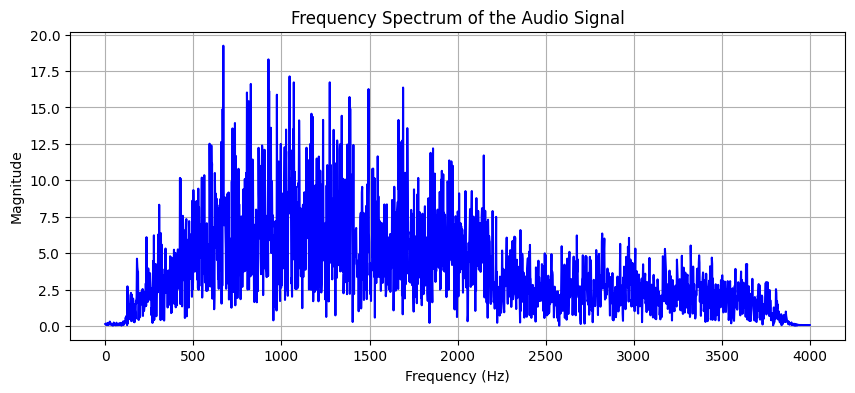

In [ ]:
fft_spectrum = np.fft.fft(noise)  # Biến đổi Fourier
frequencies = np.fft.fftfreq(4000, d=1/sr)  # Trục tần số (Hz)

# Chỉ lấy nửa phổ do tính chất đối xứng của FFT
N_half = 2000
fft_magnitude = np.abs(fft_spectrum[:N_half])  # Độ lớn phổ
frequencies = frequencies[:N_half]  # Chỉ lấy nửa đầu của trục tần số

# Vẽ phổ tần số
plt.figure(figsize=(10, 4))
plt.plot(frequencies, fft_magnitude, color='b')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of the Audio Signal")
plt.grid()
plt.show()

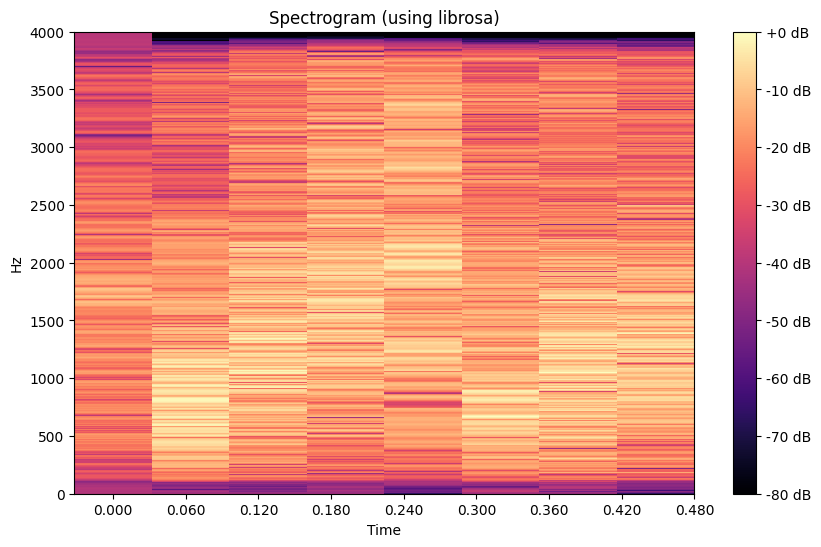

In [ ]:
import librosa
import librosa.display

# Create spectrogram using librosa
D = librosa.stft(noise, n_fft=1024, hop_length=512,center =False)
DB = librosa.power_to_db(np.abs(D)**2, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=8000, hop_length=512, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 4000)  # Set y-axis limit from 0 to 100 Hz
plt.title('Spectrogram (using librosa)')
plt.show()

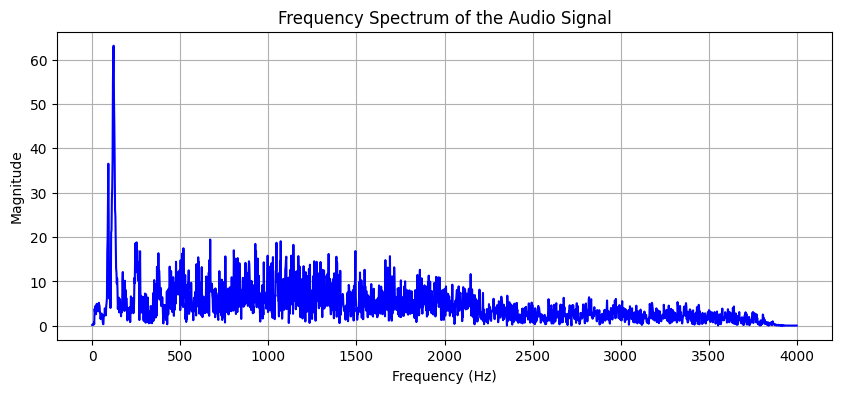

In [ ]:
fft_spectrum = np.fft.fft(mix)  # Biến đổi Fourier
frequencies = np.fft.fftfreq(4000, d=1/sr)  # Trục tần số (Hz)

# Chỉ lấy nửa phổ do tính chất đối xứng của FFT
N_half = 2000
fft_magnitude = np.abs(fft_spectrum[:N_half])  # Độ lớn phổ
frequencies = frequencies[:N_half]  # Chỉ lấy nửa đầu của trục tần số

# Vẽ phổ tần số
plt.figure(figsize=(10, 4))
plt.plot(frequencies, fft_magnitude, color='b')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of the Audio Signal")
plt.grid()
plt.show()

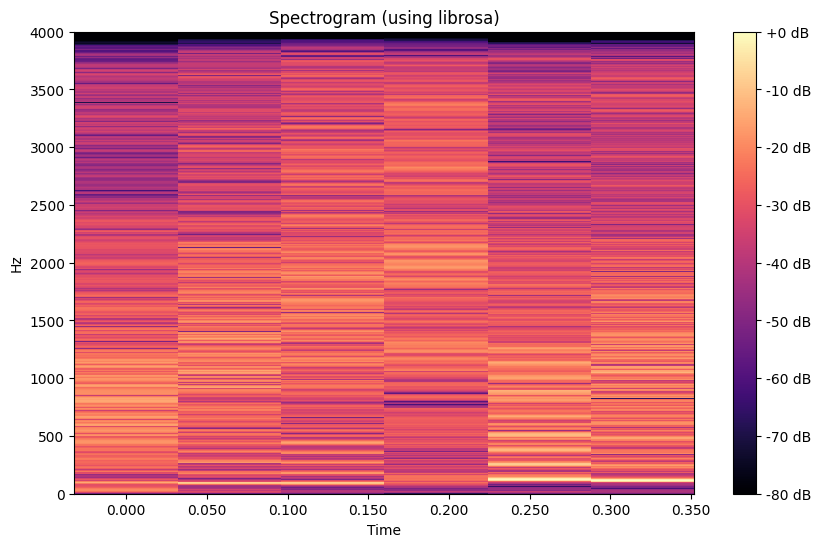

In [ ]:
import librosa
import librosa.display

# Create spectrogram using librosa
D = librosa.stft(mix, n_fft=1024, hop_length=512,center =False)
DB = librosa.power_to_db(np.abs(D)**2, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=8000, hop_length=512, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 4000)  # Set y-axis limit from 0 to 100 Hz
plt.title('Spectrogram (using librosa)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# First 2 seconds with 30 Hz signal
fs = 8000 #1000 Hz = 1000 samples/s
x = np.arange(0, 2, 1/fs) # ts = 1/fs = 1/100 = 0.01s = 10ms
print(x)
f = 30 # 3hz, 3 chu kỳ giao động/s
y1 = np.sin(2*np.pi*x*f) #+ np.sin(2*np.pi*x*5)# y = A*sin(2*pi*f*t + phi)

# Additional 2 seconds with 10 Hz signal
x2 = np.arange(2, 4, 1/fs)
f2 = 10 # 10Hz signal
y2 = np.sin(2*np.pi*x2*f2)

# Combine the signals
x_combined = np.concatenate((x, x2))
y = np.concatenate((y1, y2))

# Plot the combined signal
plt.figure(figsize=(10, 6))
plt.plot(x_combined, y)
plt.title('Sinusoidal Waveform (30Hz followed by 10Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

SAMPLES = len(y)
print(SAMPLES)

In [ ]:
import tensorflow as tf
def load_wav(filename, target_sr=8000):
    """ Load file âm thanh bằng TensorFlow """
    file_content = tf.io.read_file(filename)
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)  # Chuyển từ (samples, 1) -> (samples,)


    return wav

wav = load_wav("2.wav")

In [ ]:
for i in wav:
  print(i)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
tf.Tensor(-0.0037231445, shape=(), dtype=float32)
tf.Tensor(-0.003540039, shape=(), dtype=float32)
tf.Tensor(-0.0034484863, shape=(), dtype=float32)
tf.Tensor(-0.0033874512, shape=(), dtype=float32)
tf.Tensor(-0.003326416, shape=(), dtype=float32)
tf.Tensor(-0.0032958984, shape=(), dtype=float32)
tf.Tensor(-0.0031433105, shape=(), dtype=float32)
tf.Tensor(-0.0029907227, shape=(), dtype=float32)
tf.Tensor(-0.002746582, shape=(), dtype=float32)
tf.Tensor(-0.0024719238, shape=(), dtype=float32)
tf.Tensor(-0.002319336, shape=(), dtype=float32)
tf.Tensor(-0.0022277832, shape=(), dtype=float32)
tf.Tensor(-0.0021362305, shape=(), dtype=float32)
tf.Tensor(-0.0020446777, shape=(), dtype=float32)
tf.Tensor(-0.0018310547, shape=(), dtype=float32)
tf.Tensor(-0.0015869141, shape=(), dtype=float32)
tf.Tensor(-0.0013427734, shape=(), dtype=float32)
tf.Tensor(-0.0010986328, shape=(), dtype=float32)
tf.Tensor(-0.0009460449, shape=(), dtype=float3

KeyboardInterrupt: 

In [ ]:
max(wav)

<tf.Tensor: shape=(), dtype=float32, numpy=0.465606689453125>

In [ ]:
min(wav)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.480743408203125>